The goal here is to fit data with psychometric curves using logistic regression. 




In [49]:
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_tensor_type('torch.DoubleTensor')
criterion = torch.nn.BCELoss()

class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, bias=True, logit0=-2): 
        super(LogisticRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(1, 1, bias=bias)    
        self.logit0 = torch.nn.Parameter(logit0*torch.ones(1))
        
    def forward(self, theta):
        p0 = self.logit0.sigmoid()
        out = p0/2 + (1-p0)*self.linear(theta).sigmoid()
        return out

learning_rate = 0.04
betas = (0.9, 0.999)
num_epochs = 400
batch_size = 8
def fit_data(theta, y, 
                learning_rate =learning_rate,
                num_epochs = num_epochs,
                batch_size = batch_size,
                verbose=False):

    logistic_model = LogisticRegressionModel()

    Theta, labels = torch.Tensor(theta[:, None]), torch.Tensor(y[:, None])

    loader = DataLoader(TensorDataset(Theta, labels), batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate/len(loader), betas=betas)
    
    for epoch in range(int(num_epochs)):
        losses = []
        for Theta_, labels_ in loader:
            optimizer.zero_grad()
            outputs = logistic_model(Theta_)
            loss = criterion(outputs, labels_)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        if verbose and (epoch % (num_epochs//32) == 0) : 
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}")

    logistic_model.eval()
    return logistic_model, np.mean(losses)

In [73]:
from sklearn.linear_model import LogisticRegression
def fit_data_sklearn(theta, y, 
                num_epochs = num_epochs,
                verbose=False):
    logistic_model = LogisticRegression(solver='liblinear', max_iter=num_epochs) #, C = 3, penalty='l2', class_weight = {1 : 1 , 0 : 1})
    logistic_model.fit(theta[:, None], y)
    
    outputs = model.predict_proba(theta[:, None])[:, 0]
    outputs_, labels = torch.Tensor(outputs[:, None]), torch.Tensor(y[:, None])
    loss = criterion(outputs_, labels).item()
    if verbose: print("Loss =", loss)
    return logistic_model, loss   

In [57]:
from sklearn.linear_model import LogisticRegression
    
model = LogisticRegression(solver='liblinear', max_iter=num_epochs) #, C = 3, penalty='l2', class_weight = {1 : 1 , 0 : 1})
model.fit(theta[:, None], y)
    

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=400,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [62]:
model.predict_proba(theta[:, None])[:, 0]

array([0.25283638, 0.58425838, 0.19433671, 0.03277188, 0.63536268,
       0.63535415, 0.02900527, 0.15569929, 0.74705304, 0.23391371,
       0.7444781 , 0.74546308, 0.37465264, 0.98688015, 0.98012183,
       0.78432867, 0.90898735, 0.3375137 , 0.88758655, 0.96072408,
       0.03710484, 0.63099989, 0.469744  , 0.96176358, 0.77745983,
       0.44559726, 0.93157486, 0.30742498, 0.79851968, 0.66470138,
       0.79890466, 0.01593551, 0.51512349, 0.9169772 , 0.14013653,
       0.94090868, 0.3921961 , 0.98816096, 0.95295475, 0.39862986,
       0.16443037, 0.41240936, 0.57189016, 0.66938756, 0.96595907,
       0.83812788, 0.74329093, 0.0878517 , 0.32294889, 0.98172069,
       0.33259965, 0.70965782, 0.82464189, 0.2072926 , 0.09266027,
       0.11324903, 0.87124777, 0.67339896, 0.3290358 , 0.10365744,
       0.75114091, 0.60981939, 0.92490921, 0.93776128, 0.14286558,
       0.04693728, 0.54778291, 0.09796983, 0.31417893, 0.81409002,
       0.3142951 , 0.03172186, 0.52761702, 0.02993964, 0.99728

In [67]:
outputs_, labels = torch.Tensor(outputs[:, None]), torch.Tensor(y[:, None])
loss = criterion(outputs_, labels)

/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([200, 1])) that is different to the input size (torch.Size([200, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


In [69]:
loss.item()

0.33806764629827435

Some hyper parameters which we will tune later:

In [51]:
import numpy as np
import matplotlib.pyplot as plt

In [52]:
N = 200            
batch_size = N//4
#batch_size = N//2

N_cv = 40
seed = 42
N_test = 2000      
N_scan = 9
N_test = 5

bias = True

if False: 
#if True:
    num_epochs = 100

    N_test = 0
    N_cv = 10
    N_scan = 9


p0 = 0.02         
theta0 = 0
wt = np.pi/20      
theta_std = np.pi/6

## Let's create some synthetic data

In [53]:
def get_data(
            N = N,
            p0 = p0,
            theta0 = theta0,
            wt = wt,
            theta_std = theta_std,
            seed=seed):
    np.random.seed(seed)
    theta = np.random.randn(N)*theta_std
    a = (theta-theta0)/wt
    p = 1/(1+np.exp(-a))
    
    p = p0/2 + (1-p0) * p #add lapse rate
    y = np.random.rand(N) < p #generate data
    return theta, p, y

In [54]:
%%timeit
theta, p, y = get_data()

46.3 µs ± 20.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [55]:
theta, p, y = get_data()
logistic_model, loss = fit_data(theta, y,verbose=True) 

Iteration: 0 - Loss: 0.62486
Iteration: 12 - Loss: 0.54282
Iteration: 24 - Loss: 0.49061
Iteration: 36 - Loss: 0.45690
Iteration: 48 - Loss: 0.43313
Iteration: 60 - Loss: 0.41509
Iteration: 72 - Loss: 0.40092
Iteration: 84 - Loss: 0.38962
Iteration: 96 - Loss: 0.38035
Iteration: 108 - Loss: 0.37283
Iteration: 120 - Loss: 0.36670
Iteration: 132 - Loss: 0.36160
Iteration: 144 - Loss: 0.35739
Iteration: 156 - Loss: 0.35391
Iteration: 168 - Loss: 0.35110
Iteration: 180 - Loss: 0.34865
Iteration: 192 - Loss: 0.34675
Iteration: 204 - Loss: 0.34516
Iteration: 216 - Loss: 0.34386
Iteration: 228 - Loss: 0.34279
Iteration: 240 - Loss: 0.34190
Iteration: 252 - Loss: 0.34112
Iteration: 264 - Loss: 0.34063
Iteration: 276 - Loss: 0.33998
Iteration: 288 - Loss: 0.33953
Iteration: 300 - Loss: 0.33917
Iteration: 312 - Loss: 0.33881
Iteration: 324 - Loss: 0.33846
Iteration: 336 - Loss: 0.33819
Iteration: 348 - Loss: 0.33796
Iteration: 360 - Loss: 0.33773
Iteration: 372 - Loss: 0.33746
Iteration: 384 - L

In [48]:
with torch.no_grad():
    if bias: print(f'bias {-logistic_model.linear.bias.item()/logistic_model.linear.weight.item():.3f}; theta0 {theta0:.3f}' )
    print(f'slope {1/logistic_model.linear.weight.item():.3f} ; slope true {wt}')    
    print(f'p0 {torch.sigmoid(logistic_model.logit0).item():.3f} p0 true = {p0}')


bias 0.005; theta0 0.000
slope 0.148 ; slope true 0.15707963267948966
p0 0.008 p0 true = 0.02


loss= 0.33713330501347627


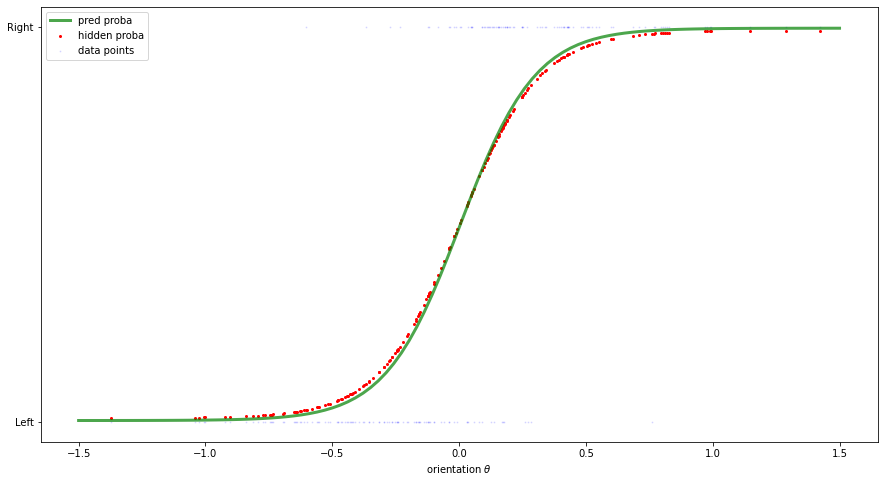

In [38]:
print('loss=', loss)
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(theta, p, s=4, color = 'r', label='hidden proba')
ax.scatter(theta, y, s=1, alpha=.1, color = 'b', label='data points')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
ax.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='pred proba')
ax.set_xlabel(r'orientation $\theta$')
ax.set_yticks([0.,1.])
ax.set_yticklabels(['Left', 'Right'])
plt.legend();

That method is fairly quick, in under 2 seconds:

In [39]:
%%timeit
logistic_model, loss = fit_data(theta, y, verbose=False)

8.2 s ± 1.66 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


let's do the same thing with `sklearn`: 

In [76]:
logistic_model, loss = fit_data_sklearn(theta, y, verbose=True) 

Loss = 1.82448751087715


That method is much quicker:

In [77]:
%%timeit
logistic_model, loss = fit_data_sklearn(theta, y, verbose=False)

The slowest run took 4.65 times longer than the fastest. This could mean that an intermediate result is being cached.
1.38 ms ± 711 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## validationfit_data_sklearn

loss= 0.33806764629827435


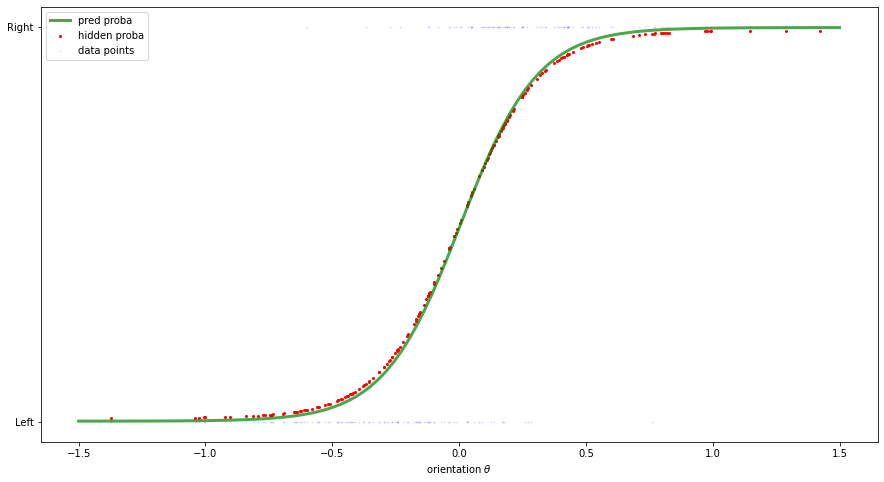

In [25]:
theta, p, y = get_data() # nouvelles données 

labels = torch.Tensor(y[:, None])
Theta = torch.Tensor(theta[:, None])
outputs = logistic_model(Theta)
loss = criterion(outputs, labels)
print('loss=', loss.item())
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(theta, p, s=4, color = 'r', label='hidden proba')
ax.scatter(theta, y, s=1, alpha=.1, color = 'b', label='data points')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
ax.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='pred proba')
ax.set_xlabel(r'orientation $\theta$')
ax.set_yticks([0.,1.])
ax.set_yticklabels(['Left', 'Right'])
plt.legend();

## influence of number of trials

In [11]:
Ns = np.logspace(1, 3, N_scan, base=10)

Ns_, losses, loss_Ps, loss_P0s = [], [], [], []

for N_ in Ns:
    for i_CV in range(N_cv):
        theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        P = torch.Tensor(p[:, None])
        
        outputs = logistic_model(Theta)
        loss = criterion(outputs, labels).item()
    
        loss_P = criterion(outputs, P).item() 
        loss_P0 = criterion(P, P).item()
        
        if i_CV==0: print(f"N: {int(N_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        loss_P0s.append(loss_P0)
        Ns_.append(N_)
        loss_Ps.append(loss_P)
        losses.append(loss)
    

N: 10, Loss: 0.33979, loss_P: 0.53212, loss_P0: 0.43535
N: 17, Loss: 0.35053, loss_P: 0.48595, loss_P0: 0.43535
N: 31, Loss: 0.41385, loss_P: 0.44543, loss_P0: 0.43535
N: 56, Loss: 0.39974, loss_P: 0.43626, loss_P0: 0.43535
N: 100, Loss: 0.40670, loss_P: 0.43942, loss_P0: 0.43535
N: 177, Loss: 0.37668, loss_P: 0.43837, loss_P0: 0.43535
N: 316, Loss: 0.37890, loss_P: 0.43705, loss_P0: 0.43535
N: 562, Loss: 0.39490, loss_P: 0.43550, loss_P0: 0.43535
N: 1000, Loss: 0.40963, loss_P: 0.43753, loss_P0: 0.43535


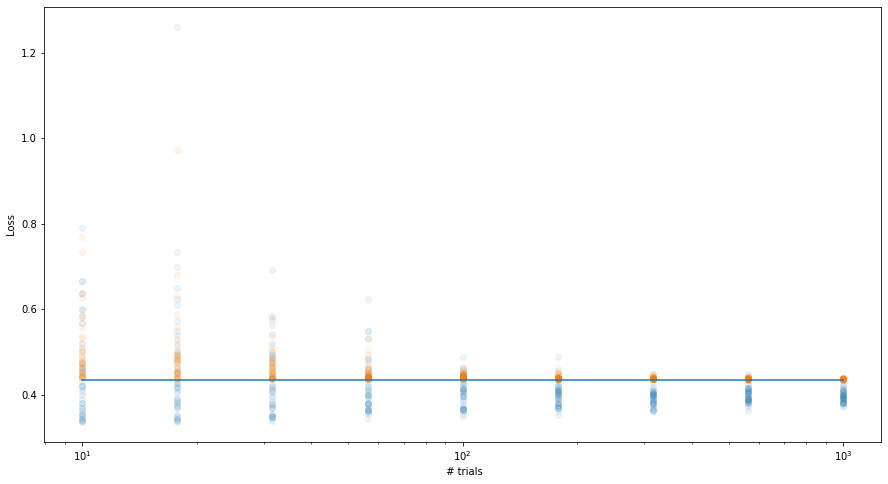

In [12]:
#plot

fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(Ns_, losses, alpha=3/N_cv, label='loss')
ax.scatter(Ns_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(Ns_, loss_P0s, label='loss_P0')

ax.set_xlabel(' # trials')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')

## influence of learning rate


In [13]:
learning_rates = learning_rate * np.logspace(-1, 1, N_scan, base=10)
learning_rates_, losses, loss_Ps, loss_P0s = [], [], [], []
for learning_rate_ in learning_rates:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, learning_rate=learning_rate_, verbose=False)

        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        loss_P = criterion(outputs, torch.Tensor(p[:, None])).item()
        loss_P0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"learning_rate: {learning_rate_:.5f}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        learning_rates_.append(learning_rate_)
        loss_P0s.append(loss_P0)
        loss_Ps.append(loss_P)
        losses.append(loss)

learning_rate: 0.00400, Loss: 0.49990, loss_P: 0.51187, loss_P0: 0.43535
learning_rate: 0.00711, Loss: 0.48874, loss_P: 0.50183, loss_P0: 0.43535
learning_rate: 0.01265, Loss: 0.45566, loss_P: 0.47488, loss_P0: 0.43535
learning_rate: 0.02249, Loss: 0.41225, loss_P: 0.44368, loss_P0: 0.43535
learning_rate: 0.04000, Loss: 0.39245, loss_P: 0.43605, loss_P0: 0.43535
learning_rate: 0.07113, Loss: 0.39355, loss_P: 0.43647, loss_P0: 0.43535
learning_rate: 0.12649, Loss: 0.40410, loss_P: 0.44424, loss_P0: 0.43535
learning_rate: 0.22494, Loss: 0.40612, loss_P: 0.44629, loss_P0: 0.43535
learning_rate: 0.40000, Loss: 0.40787, loss_P: 0.44715, loss_P0: 0.43535


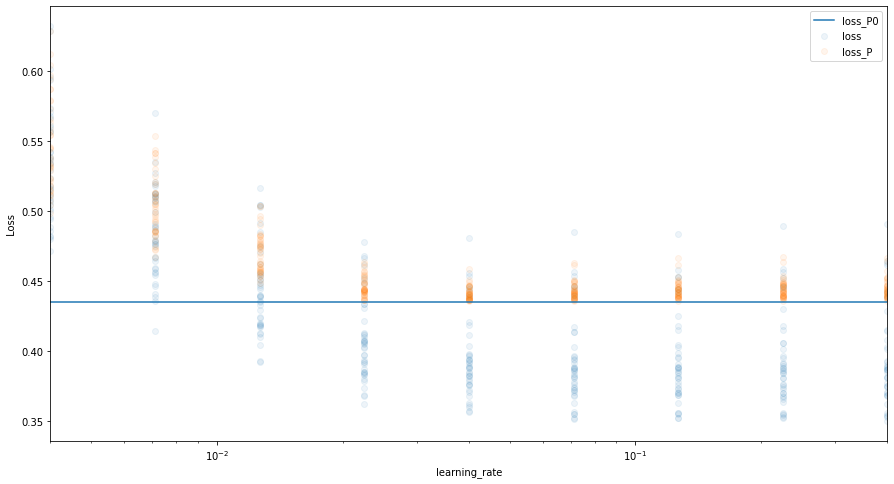

In [14]:
#influence du learning rate sur loss

fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(learning_rates_, losses, alpha=3/N_cv, label='loss')
ax.scatter(learning_rates_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(learning_rates_, loss_P0s, label='loss_P0')
ax.set_xlim(np.min(learning_rates_), np.max(learning_rates_))

ax.set_xlabel('learning_rate')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## influence du nombre d'epochs

In [15]:
num_epochss = num_epochs * np.logspace(-1, 1, N_scan, base=10)
num_epochss_, losses, loss_Ps, loss_P0s = [], [], [], []
for num_epochs_ in num_epochss:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, num_epochs=int(num_epochs_), verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        loss_P = criterion(outputs, torch.Tensor(p[:, None])).item()
        loss_P0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"num_epochs: {int(num_epochs_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        num_epochss_.append(num_epochs_)
        loss_P0s.append(loss_P0)
        loss_Ps.append(loss_P)
        losses.append(loss)

num_epochs: 40, Loss: 0.52751, loss_P: 0.53504, loss_P0: 0.43535
num_epochs: 71, Loss: 0.48951, loss_P: 0.50226, loss_P0: 0.43535
num_epochs: 126, Loss: 0.43071, loss_P: 0.45589, loss_P0: 0.43535
num_epochs: 224, Loss: 0.41135, loss_P: 0.44320, loss_P0: 0.43535
num_epochs: 400, Loss: 0.39232, loss_P: 0.43608, loss_P0: 0.43535
num_epochs: 711, Loss: 0.39876, loss_P: 0.44070, loss_P0: 0.43535
num_epochs: 1264, Loss: 0.40677, loss_P: 0.44584, loss_P0: 0.43535
num_epochs: 2249, Loss: 0.40812, loss_P: 0.44694, loss_P0: 0.43535
num_epochs: 4000, Loss: 0.40797, loss_P: 0.44697, loss_P0: 0.43535


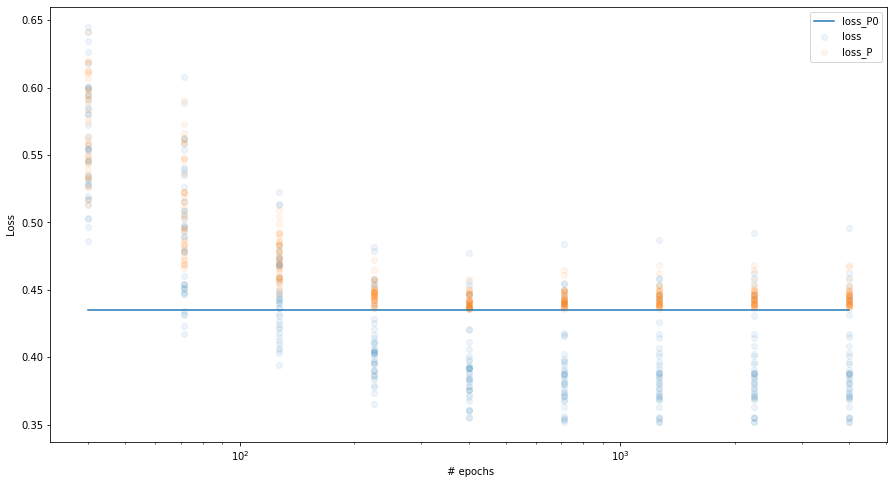

In [16]:
# influence du nbr d'epochs sur loss 
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(num_epochss_, losses, alpha=3/N_cv, label='loss')
ax.scatter(num_epochss_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(num_epochss_, loss_P0s, label='loss_P0')

ax.set_xlabel(' # epochs')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## influence de la taille du minibatch

In [ ]:
batch_sizes = N * np.logspace(-3, 0, N_scan, base=2)
batch_sizes_, losses, loss_Ps, loss_P0s = [], [], [], []
for batch_size_ in batch_sizes:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, batch_size=int(batch_size_), verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        loss_P = criterion(outputs, torch.Tensor(p[:, None])).item()
        loss_P0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"batch_size: {int(batch_size_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        batch_sizes_.append(batch_size_)
        loss_P0s.append(loss_P0)
        loss_Ps.append(loss_P)
        losses.append(loss)

batch_size: 25, Loss: 0.39291, loss_P: 0.43589, loss_P0: 0.43535
batch_size: 32, Loss: 0.39434, loss_P: 0.43580, loss_P0: 0.43535
batch_size: 42, Loss: 0.39369, loss_P: 0.43594, loss_P0: 0.43535
batch_size: 54, Loss: 0.39187, loss_P: 0.43603, loss_P0: 0.43535
batch_size: 70, Loss: 0.39214, loss_P: 0.43606, loss_P0: 0.43535
batch_size: 91, Loss: 0.39114, loss_P: 0.43575, loss_P0: 0.43535
batch_size: 118, Loss: 0.39597, loss_P: 0.43595, loss_P0: 0.43535


In [ ]:
# influence de la taille du minibatch sur loss 

fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(batch_sizes_, losses, alpha=3/N_cv, label='loss')
ax.scatter(batch_sizes_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(batch_sizes_, loss_P0s, label='loss_P0')

ax.set_xlabel(' batch_size')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## Comparaison données générées/données prédites

## Torch

In [ ]:
theta0s = theta_std*np.random.randn(N_cv)
p0s = np.linspace(0, 1, N_cv)
wts = np.logspace(-1, 1, N_cv, base=10)

p0_preds, theta0_preds, wt_preds = [],[],[]

for i_, p0_ in enumerate(p0s): 
    theta, p, y = get_data(p0=p0_,seed=seed + i_)
    logistic_model, loss = fit_data(theta, y, verbose=False)
    p0_pred =  torch.sigmoid(logistic_model.logit0).item()            
    p0_preds.append(p0_pred)
    
for i_, theta0_ in enumerate(theta0s):
    theta, p, y = get_data(theta0=theta0_,seed=seed + i_) 
    logistic_model, loss = fit_data(theta, y, verbose=False)
    theta0_pred = -logistic_model.linear.bias.item()/logistic_model.linear.weight.item() 
    theta0_preds.append(theta0_pred)
                   
for i_, wt_ in enumerate(wts):
    theta, p, y = get_data(wt=wt_, seed=seed + i_)
    logistic_model, loss = fit_data(theta, y, verbose=False)
    wt_pred = 1/logistic_model.linear.weight.item() 
    wt_preds.append(wt_pred)
    
        
      

## Sklearn

In [ ]:
def fit_lr(
            N = N,
            p0 = p0,
            theta0 = theta0,
            wt = 1/wt,
            theta_std = theta_std,
            seed = seed):
    #np.random.seed(seed)
    theta = np.random.randn(N)*theta_std
    a = (theta-theta0)*wt
    p = p0/2 + ((1-p0)/(1+np.exp(-a)))
    y = np.random.rand(N) < p 

    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(solver='liblinear', max_iter=num_epochs) #, C = 3, penalty='l2', class_weight = {1 : 1 , 0 : 1})
    model.fit(theta[:, None], y)
    return theta, p, y, model



In [ ]:
theta0_pre, wt_pre  = [],[]
    
for i_, theta0_ in enumerate(theta0s):
    theta, p, y, model = fit_lr(theta0=theta0_, seed=seed + i_)
    theta0_pre.append(-model.intercept_[0]/model.coef_[0][0])
    
for i_, wt_ in enumerate(wts):
    theta, p, y, model = fit_lr(wt=wt_, seed=seed + i_)
    wt_pre.append(model.coef_[0][0])


In [ ]:
print(min(wt_preds))

In [ ]:
# TODO : show three panels

fig, axs= plt.subplots(1, 3, figsize = (15, 8)) 

axs[0].scatter(p0s, p0_preds, label='torch')
axs[0].plot([min(p0s),max(p0s)],[min(p0_preds),max(p0_preds)],'--')
axs[0].set(xlabel='p0 réel',ylabel='p0 prédit')
axs[0].legend(loc="upper left")

axs[1].scatter(theta0s, theta0_preds,label='torch')
axs[1].scatter(theta0s, theta0_pre,label='sklearn')
#axs[1].plot([min(theta0s),max(theta0s)],[min(theta0_preds),max(theta0_preds)],'--')
axs[1].plot([min(theta0s),max(theta0s)],[min(theta0_pre),max(theta0_pre)],'--')
axs[1].set(xlabel='theta0 réel',ylabel='theta0 prédit')
axs[1].legend(loc="upper left")

axs[2].scatter(wts, wt_preds,label='torch')
axs[2].scatter(wts, wt_pre,label='sklearn')
#axs[2].plot([min(wts),max(wts)],[min(wt_preds),max(wt_preds)],'--')
axs[2].plot([min(wts),max(wts)],[min(wt_pre),max(wt_pre)],'--')
axs[2].set(xlabel='pente réelle',ylabel='pente prédite')
axs[2].legend(loc="upper left");

In [ ]:
theta0s = theta_std*np.random.randn(N_cv)
theta0ss,losses = [], []
for i_, theta0_ in enumerate(theta0s):
    for i_CV in range(N_cv):
        theta, p, y = get_data(theta0=theta0_,seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)
        loss = criterion(outputs, labels).item()
        theta0_ = -logistic_model.linear.bias.item()/logistic_model.linear.weight.item() 
        
        if i_CV==0: 
            print(f"theta0: {theta0_:.5f}, Loss: {loss:.5f}")
        theta0ss.append(theta0_)
        losses.append(loss)
           

In [ ]:
wts = np.logspace(-1, 1, N_cv, base=10)
wtss,losses = [], []

for i_, wts_ in enumerate(wts):
    for i_CV in range(N_cv):
        theta, p, y = get_data(wt=wts_,seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, verbose=False)

        if N_test>0: theta, p, y = get_data(wt=wts_,seed=seed+i_CV,N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)
        loss = criterion(outputs, labels).item()
        wt_= 1/logistic_model.linear.weight.item() 

        if i_CV==0: 
            print(f"wt: {wt_:.5f}, Loss: {loss:.5f}")
        wtss.append(wts_)
        losses.append(loss)


In [ ]:
p0s = np.linspace(0, 1, N_cv)
p0ss,losses = [], []

for i_, p0s_ in enumerate(p0s):
    for i_CV in range(N_cv):
        theta, p, y = get_data(p0=p0s_,seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, verbose=False)

        if N_test>0: theta, p, y = get_data(p0=p0s_,seed=seed+i_CV,N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)
        loss = criterion(outputs, labels).item()
        p0_ =  torch.sigmoid(logistic_model.logit0).item()            

        if i_CV==0: 
            print(f"p0: {p0_:.5f}, Loss: {loss:.5f}")
        p0ss.append(p0_)
        losses.append(loss)


## synthesizing results

In [ ]:
fig, axs= plt.subplots(1, 3, figsize = (15, 8))

axs[0].scatter(p0ss, losses,label='p0',marker=".")
axs[0].set_xlabel('p0')
axs[0].set_ylabel('Loss')


axs[1].scatter(theta0ss, losses,label='theta0',marker=".")
axs[1].set_xlabel('theta0')
axs[1].set_ylabel('Loss')
axs[1].set(xlim=(-0.5, 1.5))
  

axs[2].scatter(wtss, losses,label='wt',marker=".")
axs[2].set_xlabel('wt')
axs[2].set_ylabel('Loss')
axs[2].set(xlim=(0, 1))